### Chapter 8

### DeepDream

DeepDream is an artistic image-modification technique that uses the representations
learned by convolutional neural networks. It was first released by Google in the summer of 2015, as an implementation written using the Caffe deep-learning library (this
was several months before the first public release of TensorFlow).
 
It quickly became
an internet sensation thanks to the trippy pictures it could generate, full of algorithmic pareidolia artifacts, bird feathers, and dog eyes—a
byproduct of the fact that the DeepDream convnet was trained on ImageNet, where
dog breeds and bird species are vastly overrepresented.

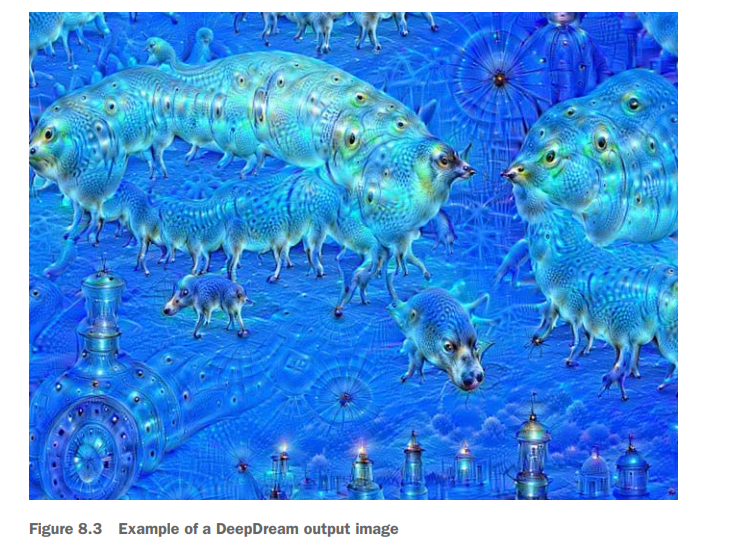

The DeepDream algorithm is almost identical to the convnet filter-visualization technique introduced in chapter 5, consisting of running a convnet in reverse: doing gradient ascent on the input to the convnet in order to maximize the activation of a
specific filter in an upper layer of the convnet. DeepDream uses this same idea, with a
few simple differences:
* With DeepDream, we try to maximize the activation of entire layers rather
than that of a specific filter, thus mixing together visualizations of large numbers of features at once
* We start not from blank, slightly noisy input, but rather from an existing
image—thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.
* The input images are processed at different scales (called `octaves`), which
improves the quality of the visualizations.

### Implementing DeepDream

We’ll start from a convnet pretrained on ImageNet. In Keras, many such convnets are
available: `VGG16`, `VGG19`, `Xception`, `ResNet50`, and so on. 

We can implement DeepDream with any of them, but our convnet of choice will naturally affect our visualizations, because different convnet architectures result in different learned features. The
convnet used in the original DeepDream release was an **Inception model**, and in practice Inception is known to produce nice-looking DeepDreams, so we’ll use the Inception V3 model.

In [8]:
#  Loading the pretrained Inception V3 model

from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

K.set_learning_phase(0) # We won’t be training the model, so this command disables all training-specific operations.


In [9]:
# Builds the Inception V3 network, without its convolutional base.
# The model will be loaded with pretrained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

Next, we’ll compute the loss: **the quantity we’ll seek to maximize during the gradient-ascent
process**. 

In chapter 5, for filter visualization, we tried to maximize the value of a specific filter
in a specific layer. Here, we’ll simultaneously maximize the activation of all filters in a number
of layers. Specifically, we’ll maximize a weighted sum of the **L2 norm** of the activations of a set
of high-level layers. 

The exact set of layers we choose (as well as their contribution to the final
loss) has a major influence on the visuals we’ll be able to produce, so we want to make these
parameters easily configurable. 
* Lower layers result in geometric patterns, whereas 
* higher layers result in visuals in which we can recognize some classes from ImageNet (for example, birds or
dogs). 

We’ll start from a somewhat arbitrary configuration involving four layers—but we’ll
definitely want to explore many different configurations later.

In [10]:
# Setting up the DeepDream configuration

layer_contributions = {'mixed2': 0.2,'mixed3': 3.,'mixed4': 2.,'mixed5': 1.5,}


Above Dictionary mapping layer names to a coefficient quantifying
how much the layer’s activation contributes to the loss
we’ll seek to maximize. 

Note that the layer names are
hardcoded in the built-in Inception V3 application. We can
list all layer names using `model.summary()`.

In [11]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

Now, let’s define a tensor that contains the loss: **the weighted sum of the L2 norm of
the activations of the layers in listing above dictionary**.

In [12]:
layer_dict = dict([(layer.name, layer) for layer in model.layers]) # Creates a dictionary that maps layer names to layer instances
loss = K.variable(0.) # We’ll define the loss by adding layer contributions to this scalar variable.

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output # Retrieves the layer’s output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    # Adds the L2 norm of the features of a layerto the loss. We avoid border artifacts by
    # only involving nonborder pixels in the loss.
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling 

Next, we can set up the gradient-ascent process.

In [13]:
# Gradient-ascent process

import tensorflow as tf
tf.compat.v1.disable_eager_execution() # eager execution is disabled

dream = model.input # This tensor holds the generated image: the dream.
grads = K.gradients(loss, dream)[0] # Computes the gradients of the dream with regard to the loss
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # Normalizes the gradients (important trick)

# Sets up a Keras function to retrieve the value of the loss and gradients, given an input image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# Below function runs gradient ascent for a number of iterations.
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Finally: the actual DeepDream algorithm. First, we define a list of `scales` (also called
`octaves`) at which to process the images. Each successive scale is larger than the previous one by a factor of 1.4 (it’s 40% larger): we start by processing a small image and
then increasingly scale it up.

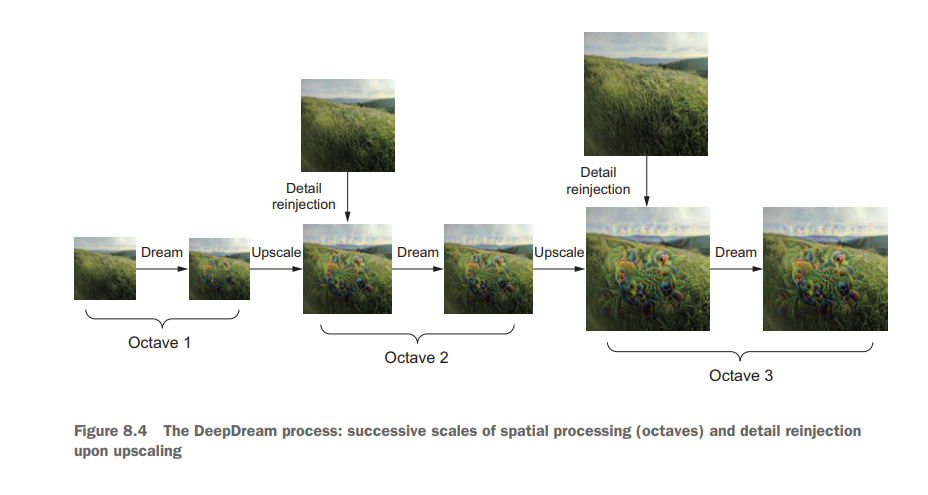

For each successive scale, from the smallest to the largest, we run gradient ascent to
maximize the loss we previously defined, at that scale. After each gradient ascent run,
we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive scale-up (resulting in
increasingly blurry or pixelated images), we can use a simple trick: after each scaleup, we’ll reinject the lost details back into the image, which is possible because we
know what the original image should look like at the larger scale. Given a small image
size `S` and a larger image size `L`, we can compute the difference between the original
image resized to size `L` and the original resized to size `S`—this difference quantifies the
details lost when going from `S` to `L`

In [34]:
# Auxiliary functions

import scipy
from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,float(size[0]) / img.shape[1],float(size[1]) / img.shape[2],1)
    return scipy.ndimage.zoom(img, factors, order=1)

import imageio
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    # scipy.misc.imsave(fname, pil_img) # depricated
    imageio.imwrite(fname, pil_img)

# Util function to open, resize, and format pictures into tensors that Inception V3 can process
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


# Util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3)) # Undoes preprocessing that was performed by inception_v3.preprocess_input
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Note that below code uses the above straightforward auxiliary Numpy functions,
which all do as their names suggest. They require that we have SciPy installed.

In [35]:
#  Running gradient ascent over different successive scales

import numpy as np

# Playing with these hyperparameters will let us achieve new effects.
step = 0.01 # Gradient ascent step size
num_octave = 3 # Number of scales at which to run gradient ascent
octave_scale = 1.4 # Size ratio between scales

iterations = 20 # Number of ascent steps to run at each scale

# If the loss grows larger than 10, we’ll interrupt the gradient-ascent process to avoid ugly artifacts
max_loss = 10.

base_image_path = 'elephant_cam.jpg'

img = preprocess_image(base_image_path) # Loads the base image into a Numpy array (function is defined above)

In [36]:
# Prepares a list of shape tuples defining the different scales at which to run gradient ascent

original_shape = img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
# Reverses the list of shapes so they’re in increasing order
successive_shapes = successive_shapes[::-1]

In [37]:
# Resizes the Numpy array of the image to the smallest scale

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [38]:
import imageio 

In [39]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape) # Scales up the dream image
    img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss) # Runs gradient ascent, altering the dream
    
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) # Scales up the smaller version of the original image: it will be pixellated.
    same_size_original = resize_img(original_img, shape) # Computes the high-quality version of the original image at this size
    lost_detail = same_size_original - upscaled_shrunk_original_img # The difference between the two is the detail that was lost when scaling up.
    
    img += lost_detail # Reinjects lost detail into the dream
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (183, 305)
...Loss value at 0 : 1.5411227
...Loss value at 1 : 1.9451071
...Loss value at 2 : 2.6296651
...Loss value at 3 : 3.3084588
...Loss value at 4 : 3.9584413
...Loss value at 5 : 4.615105
...Loss value at 6 : 5.20599
...Loss value at 7 : 5.8116803
...Loss value at 8 : 6.4131145
...Loss value at 9 : 6.9727006
...Loss value at 10 : 7.594704
...Loss value at 11 : 8.101818
...Loss value at 12 : 8.567435
...Loss value at 13 : 9.052009
...Loss value at 14 : 9.50925
...Loss value at 15 : 9.937108
Processing image shape (256, 427)
...Loss value at 0 : 2.718043
...Loss value at 1 : 3.973322
...Loss value at 2 : 5.0558167
...Loss value at 3 : 5.9622087
...Loss value at 4 : 6.8397336
...Loss value at 5 : 7.615896
...Loss value at 6 : 8.351808
...Loss value at 7 : 9.025688
...Loss value at 8 : 9.631513
Processing image shape (359, 599)
...Loss value at 0 : 2.8731365
...Loss value at 1 : 4.1230197
...Loss value at 2 : 5.1854877
...Loss value at 3 : 6.1226454
...Loss v

NOTE Because the original Inception V3 network was trained to recognize
concepts in images of size `299 × 299`, and given that the process involves scaling the images down by a reasonable factor, the DeepDream implementation
produces much better results on images that are somewhere between `300 ×300` and `400 × 400`. Regardless, we can run the same code on images of any size and any ratio.

Starting from a photograph taken in the small hills between San Francisco Bay and
the Google campus, we obtained the DeepDream shown below.

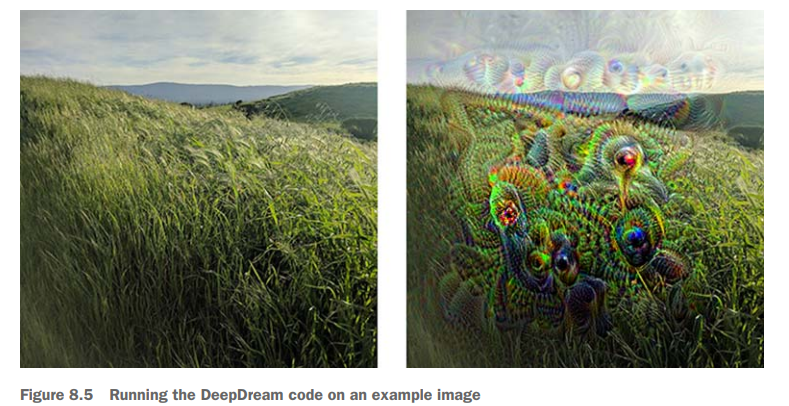

We strongly suggest that we explore what we can do by adjusting which layers we
use in our loss. 
* Layers that are lower in the network contain more-local, less-abstract
representations and lead to dream patterns that look more geometric. 
* Layers that are
higher up lead to more-recognizable visual patterns based on the most common
objects found in ImageNet, such as dog eyes, bird feathers, and so on. 

We can use random generation of the parameters in the `layer_contributions` dictionary to
quickly explore many different layer combinations.

Figure below shows a range of results
obtained using different layer configurations, from an image of a delicious homemade pastry. 

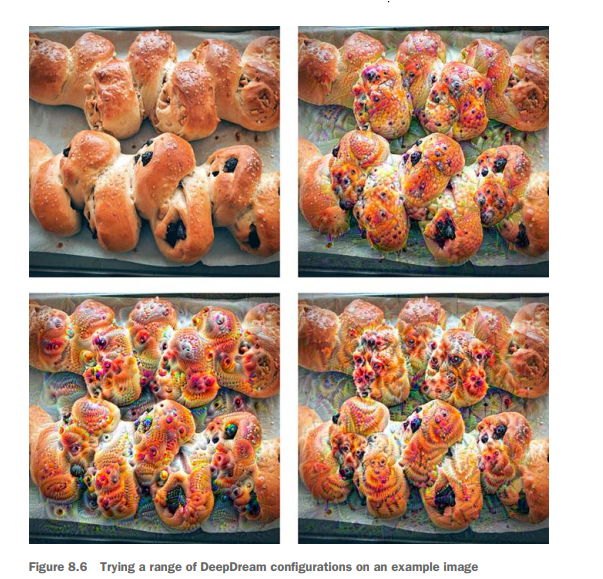

### Conclusion up
 
* DeepDream consists of running a convnet in reverse to generate inputs based on the representations learned by the network.
* The results produced are fun and somewhat similar to the visual artifacts
induced in humans by the disruption of the visual cortex via psychedelics.
* Note that the process isn’t specific to image models or even to convnets. It can
be done for speech, music, and more. 